In [1]:
%load_ext zipline
%load_ext watermark
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# 1. Импортируем библиотеки

In [2]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

from collections import OrderedDict
import pytz

# необходимые функции zipline
from zipline.api import (order, record, symbol, set_benchmark, order_target_percent, get_open_orders, order_target, 
                        schedule_function, date_rules, time_rules, order_percent, symbols)
# комиссии
from zipline.finance import commission
from zipline.finance import slippage
from zipline.finance.slippage import SlippageModel

# выбор календаря по которому происходит торговля
from trading_calendars.always_open import AlwaysOpenCalendar

import zipline

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime, date

# aинансовые данные
from yahoofinancials import YahooFinancials

# отчёт
import pyfolio as pf

# import helper functions 
import qf_helper_functions as qf

import pypfopt
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

import pylab

from tqdm import tqdm

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import style
from matplotlib import mlab
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import matplotlib.ticker as mtick
import matplotlib.patches as patches
%matplotlib inline

plt.style.use('default')
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 200

#векторный формат
%config InlineBackend.figure_format = 'svg'

from tqdm import tqdm

from __future__ import division
import numpy as np
from matplotlib import pyplot as plt
from numpy.linalg import inv,pinv
from scipy.optimize import minimize

In [3]:
# risk budgeting optimization
def calculate_portfolio_var(w,V):
    # function that calculates portfolio risk
    w = np.matrix(w)
    return (w*V*w.T)[0,0]

def calculate_risk_contribution(w,V):
    # function that calculates asset contribution to total risk
    w = np.matrix(w)
    sigma = np.sqrt(calculate_portfolio_var(w,V))
    # Marginal Risk Contribution
    MRC = V*w.T
    # Risk Contribution
    RC = np.multiply(MRC,w.T)/sigma
    return RC

def risk_budget_objective(x,pars):
    # calculate portfolio risk
    V = pars[0]# covariance table
    x_t = pars[1] # risk target in percent of portfolio risk
    sig_p =  np.sqrt(calculate_portfolio_var(x,V)) # portfolio sigma
    risk_target = np.asmatrix(np.multiply(sig_p,x_t))
    asset_RC = calculate_risk_contribution(x,V)
    J = sum(np.square(asset_RC-risk_target.T))[0,0] # sum of squared error
    return J

def total_weight_constraint(x):
    return np.sum(x)-1.0

def long_only_constraint(x):
    return x

In [4]:
# Custom slippage model
class InstantSlippage(SlippageModel):
    
    def process_order(self, data, order):
        # Use price from previous bar
        price = data.history(order.sid, 'price', 2, '1d')[0]
        
        # Alternative: Use current bar's open, instead of close
        # price = data.current(order.sid, 'open')

        return (price, order.amount)

# 2. Загрузка данных

In [5]:
def download_csv_data(ticker, start_date, end_date, freq, path):
    
    yahoo_financials = YahooFinancials(ticker)

    df = yahoo_financials.get_historical_price_data(start_date, end_date, freq)
    df = pd.DataFrame(df[ticker]['prices']).drop(['date'], axis=1) \
            .rename(columns={'formatted_date':'date'}) \
            .loc[:, ['date','open','high','low','close', 'adjclose', 'volume']] \
            .set_index('date')
    df.index = pd.to_datetime(df.index)
    df['dividend'] = 0
    df['split'] = 1

    # save data to csv for later ingestion
    df.to_csv(path, header=True, index=True)

    # plot the time series
    df.close.plot(title='{} prices --- {}:{}'.format(ticker, start_date, end_date), color='green');
    plt.yscale('log')

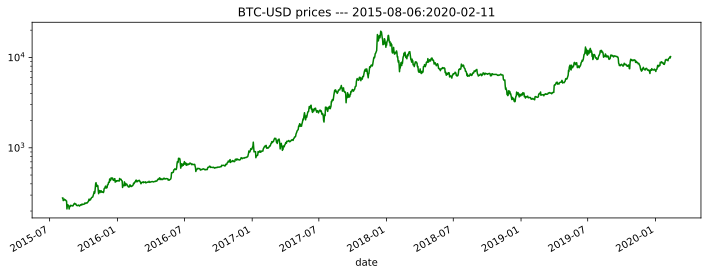

In [6]:
download_csv_data(ticker='BTC-USD', 
                  start_date='2015-08-06', 
                  end_date='2020-02-11', 
                  freq='daily', 
                  path='data/BTC.csv')

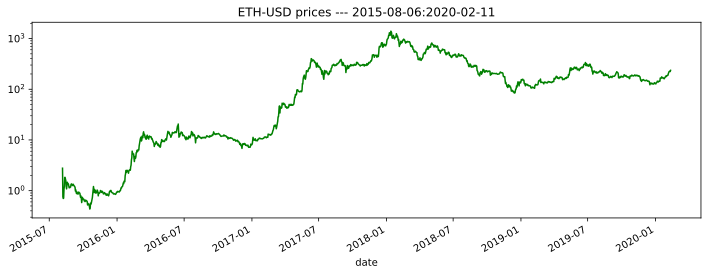

In [7]:
download_csv_data(ticker='ETH-USD', 
                  start_date='2015-08-06', 
                  end_date='2020-02-11', 
                  freq='daily', 
                  path='data/ETH.csv')

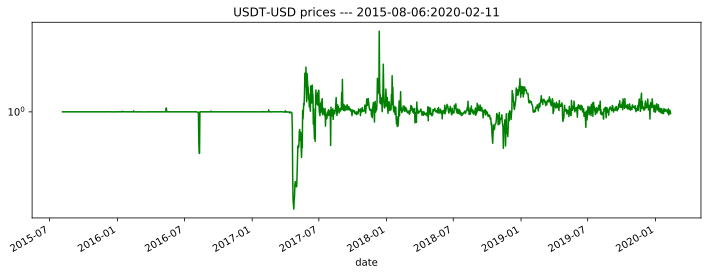

In [8]:
download_csv_data(ticker='USDT-USD', 
                  start_date='2015-08-06', 
                  end_date='2020-02-11', 
                  freq='daily', 
                  path='data/USDT.csv')

In [9]:
# Список финансовых инструментов в портфеле
TIKERS = ['BTC', 'ETH', 'USDT']

# Данные которые будут использоваться в дальнейшем
COLUMNS = ['open', 'close', 'adjclose']

In [10]:
data = OrderedDict()

for tiker in TIKERS:
    data[tiker] = pd.read_csv("data/{}.csv".format(tiker), index_col=0, parse_dates=['date'])
    data[tiker] = data[tiker][COLUMNS]
    data[tiker] = data[tiker].resample("1d").mean()
    data[tiker].fillna(method="ffill", inplace=True)
    data[tiker]['close'] = data[tiker]['adjclose']
    data[tiker]['open'] = data[tiker]['adjclose']
    del data[tiker]['adjclose']
    print(data[tiker].head())
COLUMNS = ['open', 'close']

                  open       close
date                              
2015-08-05  278.576996  278.576996
2015-08-06  279.584991  279.584991
2015-08-07  260.997009  260.997009
2015-08-08  265.083008  265.083008
2015-08-09  264.470001  264.470001
                open     close
date                          
2015-08-06  2.772120  2.772120
2015-08-07  0.753325  0.753325
2015-08-08  0.701897  0.701897
2015-08-09  0.708448  0.708448
2015-08-10  1.067860  1.067860
            open  close
date                   
2015-08-05   1.0    1.0
2015-08-06   1.0    1.0
2015-08-07   1.0    1.0
2015-08-08   1.0    1.0
2015-08-09   1.0    1.0


In [11]:
panel = pd.Panel(data)
panel.minor_axis = COLUMNS
panel.major_axis = panel.major_axis.tz_localize(pytz.utc)
print(panel)

<class 'pandas.core.panel.Panel'>
Dimensions: 3 (items) x 1652 (major_axis) x 2 (minor_axis)
Items axis: BTC to USDT
Major_axis axis: 2015-08-05 00:00:00+00:00 to 2020-02-11 00:00:00+00:00
Minor_axis axis: open to close


# Research

In [12]:
WEIGHTS = [0.545, 0.295, 0.159]
COMMISSION = 0.0007
DELTA = 0.5
REBALANCE_PERIOD = 50

In [13]:
def initialize(context):
    
    context.set_commission(commission.PerDollar(cost=COMMISSION))
    context.set_slippage(InstantSlippage())
    
    #set_benchmark(symbol('BTC'))
    
    context.tikers = TIKERS
    context.assets = [context.symbol(symbol) for symbol in context.tikers]
    
    context.weights = WEIGHTS
    context.n_assets = len(context.assets)
    
    context.rebalance_count = 0
    
    context.rebalance_period = REBALANCE_PERIOD
    
    context.time = 0

In [14]:
def handle_data(context, data):
    
    
    if context.time == 0 or (context.time % context.rebalance_period == 0):
        
        for i, asset in enumerate(context.assets):
            order_target_percent(asset, context.weights[i])      
        context.time += 1
        
        
    else:
            for i, asset in enumerate(context.assets):
                if abs(context.portfolio.current_portfolio_weights.get(key = asset) - 
                                                                   context.weights[i])/context.weights[i] > DELTA:
                    for j, asset in enumerate(context.assets):
                        order_target_percent(asset, context.weights[j])
                        
                    #context.rebalance_count += 1
                    context.time = 1
                        
                    return
                
                context.time += 1    

In [15]:
perf = zipline.run_algorithm(start=datetime(2015, 10, 10, 0, 0, 0, 0, pytz.utc),
                              end=datetime(2020, 2, 11, 0, 0, 0, 0, pytz.utc),
                              initialize=initialize,
                              capital_base=10000000,
                              handle_data=handle_data,
                              data=panel)

In [16]:
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)

In [17]:
#Поправляем индексацию
new_index = pd.Series(pd.to_datetime(positions.index).date).map(lambda x: x.strftime('%Y-%m-%d'))
weights_df = pd.DataFrame.from_records(positions, index=new_index)
weights_df.head()

sid,Equity(0 [BTC]),Equity(1 [USDT]),Equity(2 [ETH]),cash
2015-10-13,5.503944e+06,1590000.0,2.538867e+06,1577.640148
2015-10-14,5.554858e+06,1590000.0,2.727765e+06,1577.640148
2015-10-15,5.741584e+06,1590000.0,2.604537e+06,1577.640148
2015-10-16,5.911319e+06,1590000.0,2.656400e+06,1577.640148
2015-10-19,5.885611e+06,1590000.0,2.110977e+06,1577.640148


In [18]:
weights_df.columns = ['ETH', 'USDT', 'BTC', 'cash']

In [19]:
weights_df['USDT'] = weights_df['USDT'] + weights_df['cash']

In [20]:
weights_df = weights_df.drop(['cash'], axis=1)

In [21]:
# Поправляем названия столбцов
weights_df.columns = ['ETH', 'USDT', 'BTC']

# Нормирование весов в файле
norm_weights_df = weights_df.copy()
norm_weights_df['BTC'] = 100 * weights_df['BTC']/(weights_df['ETH'] + weights_df['BTC'] + weights_df['USDT'])    
norm_weights_df['ETH'] = 100* weights_df['ETH']/(weights_df['ETH'] + weights_df['BTC'] + weights_df['USDT'])
norm_weights_df['USDT'] = 100 * weights_df['USDT']/(weights_df['ETH'] + weights_df['BTC'] + weights_df['USDT'])
    
# convert date objects from pandas format to python datetime
norm_weights_df.index = [pd.to_datetime(date, format='%Y-%m-%d').date() for date in norm_weights_df.index]
                                              
norm_weights_df.head()

,ETH,USDT,BTC
2015-10-13,57.128105,16.519757,26.352138
2015-10-14,56.256279,16.118547,27.625174
2015-10-15,57.775792,16.015555,26.208653
2015-10-16,58.186301,15.666218,26.147480
2015-10-19,61.384123,16.599397,22.016480


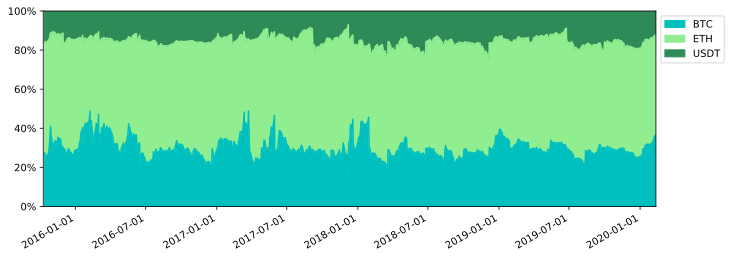

In [22]:
plt.rcParams['figure.figsize'] = [11, 4]

norm_weights_df = norm_weights_df[['BTC', 'ETH', 'USDT']]
# plot the results
col = ['c', 'lightgreen', 'seagreen']
ax = norm_weights_df.plot(kind='area', stacked=True, color = col) # stacked=True показывает веса в одном столбце

# set monthly locator

##### Градуировка https://matplotlib.org/3.1.0/gallery/ticks_and_spines/tick-locators.html
#ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
# set formatter
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
# set font and rotation for date tick labels
plt.gcf().autofmt_xdate()

ax.tick_params(axis = 'both', direction = 'out')
#ax.set(title = 'Paradigm strategy', ylabel='Allocation')
ax.legend(bbox_to_anchor=(1,1))
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set(xlim=(datetime(2015, 10, 10, 0, 0, 0, 0, pytz.utc), 
             datetime(2020, 2, 11, 0, 0, 0, 0, pytz.utc)), ylim=(0, 100))
plt.show()

# Статистика

In [31]:
WEIGHTS = [0.545, 0.295, 0.159]
COMMISSION = 0.0007

In [ ]:
# empty lists to store returns, volatility and weights of imiginary portfolios
port_returns = []
port_volatility = []
sharpe_ratio = []
threshold = []
rebalance_frequency = []

for period in tqdm(range(105, 253)):
    
    for DELTA in tqdm(np.arange(1, 100.5, 0.5)):

        DELTA = DELTA/100

        def initialize(context):

            context.set_commission(commission.PerDollar(cost=COMMISSION))
            context.set_slippage(InstantSlippage())

            #set_benchmark(symbol('BTC'))

            context.tikers = TIKERS
            context.assets = [context.symbol(symbol) for symbol in context.tikers]

            context.weights = WEIGHTS
            context.n_assets = len(context.assets)

            context.rebalance_count = 0


            context.rebalance_period = period
            context.time = 0

        def handle_data(context, data):


            if context.time == 0 or (context.time % context.rebalance_period == 0):

                for i, asset in enumerate(context.assets):
                    order_target_percent(asset, context.weights[i])      
                context.time += 1


            else:
                    for i, asset in enumerate(context.assets):
                        if abs(context.portfolio.current_portfolio_weights.get(key = asset) - 
                                                                       context.weights[i])/context.weights[i] > DELTA:
                            for j, asset in enumerate(context.assets):
                                order_target_percent(asset, context.weights[j])

                            context.rebalance_count += 1
                            context.time = 1

                            return

                        context.time += 1 

        perf = zipline.run_algorithm(start=datetime(2015, 10, 10, 0, 0, 0, 0, pytz.utc),
                                      end=datetime(2020, 2, 11, 0, 0, 0, 0, pytz.utc),
                                      initialize=initialize,
                                      capital_base=10000000,
                                      #trading_calendar=AlwaysOpenCalendar(),
                                      handle_data=handle_data,
                                      data=panel)
        returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)

        sharpe_ratio.append(qf.get_performance_summary(returns).sharpe_ratio)
        port_returns.append(qf.get_performance_summary(returns).annualized_returns * 100)
        port_volatility.append(qf.get_performance_summary(returns).annual_volatility * 100)
        threshold.append(DELTA)
        rebalance_frequency.append(period)



  0%|                                                                                          | 0/148 [00:00<?, ?it/s]


  0%|                                                                                          | 0/199 [00:00<?, ?it/s]


  1%|▍                                                                                 | 1/199 [00:08<26:32,  8.05s/it]


  1%|▊                                                                                 | 2/199 [00:15<25:43,  7.83s/it]


  2%|█▏                                                                                | 3/199 [00:22<24:40,  7.55s/it]


  2%|█▋                                                                                | 4/199 [00:28<23:22,  7.19s/it]


  3%|██                                                                                | 5/199 [00:34<22:05,  6.83s/it]


  3%|██▍                                                                               | 6/199 [00:40<20:56,  6.51s/it]


  4%|██▉              

In [ ]:
# a dictionary for Returns and Risk values of each portfolio
portfolio = {'Returns': port_returns,
             'Volatility': port_volatility,
             'Sharpe Ratio': sharpe_ratio,
             'Threshold': threshold,
             'Rebalance Frequency': rebalance_frequency}

# extend original dictionary to accomodate each ticker and weight in the portfolio
#for counter,symbol in enumerate(TIKERS):
    #portfolio[symbol] = [Weight[counter] for Weight in stock_weights]
    
# make a nice dataframe of the extended dictionary
df = pd.DataFrame(portfolio)

# get better labels for desired arrangement of columns
column_order = ['Returns', 'Volatility', 'Sharpe Ratio', 'Threshold', 'Rebalance Frequency']

# reorder dataframe columns
df = df[column_order]

In [ ]:
#df.to_csv('USDTRebalanceThreshold101015_3D_105.csv')

In [29]:
df = pd.read_csv('USDTRebalanceThreshold101015_3D.csv', index_col=0)

In [30]:
df

,Returns,Volatility,Sharpe Ratio,Threshold,Rebalance Frequency
0,176.511459,66.339133,1.864740,0.010,1
1,176.511459,66.339133,1.864740,0.015,1
2,176.511459,66.339133,1.864740,0.020,1
3,176.511459,66.339133,1.864740,0.025,1
4,176.511459,66.339133,1.864740,0.030,1
5,176.511459,66.339133,1.864740,0.035,1
6,176.511459,66.339133,1.864740,0.040,1
7,176.511459,66.339133,1.864740,0.045,1
8,176.511459,66.339133,1.864740,0.050,1
9,176.511459,66.339133,1.864740,0.055,1


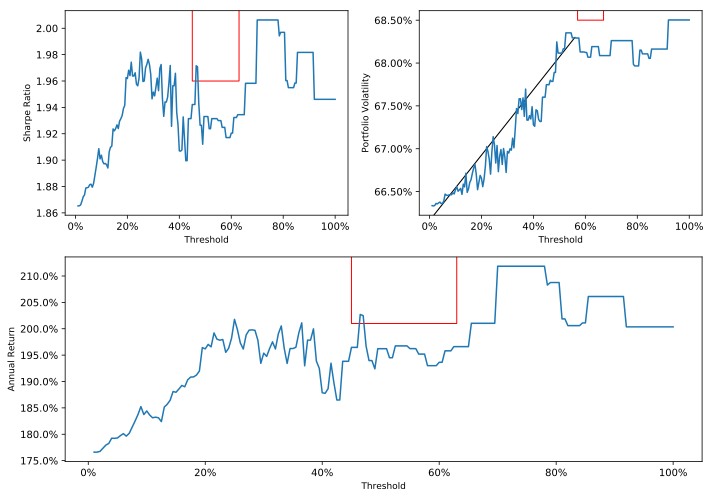

In [120]:
plt.rcParams['figure.figsize'] = [10, 7]

fig = plt.figure()

ax1 = plt.subplot(221)
ax1.plot(df['Threshold'], df['Sharpe Ratio'])
#ax1.set_ylabel('Sharpe Ratio')
ax1.xaxis.set_major_formatter(mtick.PercentFormatter())
ax1.set_xlabel('Threshold', fontsize = 9)
ax1.set_ylabel('Sharpe Ratio', fontsize = 9)


ax2 = plt.subplot(222)
ax2.plot(df['Threshold'], df['Volatility'])
#ax2.set_ylabel('Volatility')
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())
ax2.xaxis.set_major_formatter(mtick.PercentFormatter())
ax2.set_xlabel('Threshold', fontsize = 9)
ax2.set_ylabel('Portfolio Volatility', fontsize = 9)


ax3 = plt.subplot(212)
ax3.plot(df['Threshold'], df['Returns'])
#ax3.set_ylabel('Returns')
ax3.yaxis.set_major_formatter(mtick.PercentFormatter())
ax3.xaxis.set_major_formatter(mtick.PercentFormatter())
ax3.set_xlabel('Threshold', fontsize = 9)
ax3.set_ylabel('Annual Return', fontsize = 9)

#ax1.arrow(34, 1.89, 22, 0.16)
#ax1.arrow(60, 1.98, 190, -0.23)

ax2.arrow(1, 66.2, 55, 2.1)
#ax2.arrow(68, 73.4, 32, 0.3)

#ax3.arrow(34, 185, 24, 40)
#ax3.arrow(60, 235, 195, -26)

rect1 = patches.Rectangle((45,1.96),18,0.09,linewidth=1,edgecolor='r',facecolor='none')
rect2 = patches.Rectangle((57,68.5),10,3.5,linewidth=1,edgecolor='r',facecolor='none')
rect3 = patches.Rectangle((45,201),18,19,linewidth=1,edgecolor='r',facecolor='none')

ax1.add_patch(rect1)
ax2.add_patch(rect2)
ax3.add_patch(rect3)


plt.tight_layout()

In [83]:
fig.savefig('USDTThreshold_101015_252.png', transparent=False, dpi=500, bbox_inches="tight")